In [51]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets, utils

In [ ]:
def mnist_data():
  compose = transforms.Compose(
      [transforms.ToTensor(),
       transforms.Normalize((0.5),(0.5))]
  )
  return datasets.MNIST(root='./dataset', train=True,
                        transform=compose,download=True)
  
data = mnist_data()

In [ ]:
data_loader = torch.utils.data.DataLoader(data, batch_size=100,
                                          shuffle=True)
num_batches = len(data_loader)

In [ ]:
class DiscriminatorNet(torch.nn.Module):
  """
  A three layer discriminator model
  """
  def __init__(self):
    super(DiscriminatorNet, self).__init__()
    n_features = 784
    n_out = 1

    self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
    self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
    self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
    self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )
    
  def forward(self,x):
    x = self.hidden0(x)
    x = self.hidden1(x)
    x = self.hidden2(x)
    x = self.out(x)
    return x

discriminator = DiscriminatorNet()

In [ ]:
def images_to_vectors(images):
  return images.view(images.size(0), 784)

def vectors_to_images(vectors):
  return vectors.view(vectors.size(0), 1,28,28)

In [ ]:
class GeneratorNet(torch.nn.Module):
  """
  A three layer generative neural network
  """

  def __init__(self):
    super(GeneratorNet, self).__init__()
    n_features = 100
    n_out = 784

    self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
    self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
    self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
    self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )
    
  def forward(self,x):
     x = self.hidden0(x)
     x = self.hidden1(x)
     x = self.hidden2(x)
     x = self.out(x)
     return x


generator = GeneratorNet()


In [ ]:
def noise(size):
    n = Variable(torch.randn(size, 100))
    if torch.cuda.is_available(): return n.cuda() 
    return n

In [ ]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [ ]:
loss = nn.BCELoss()

In [ ]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available(): return data.cuda()
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
  N = real_data.size(0)
  optimizer.zero_grad()

  # Train on real data
  pred_real = discriminator(real_data)
  error_real = loss(pred_real, ones_target(N))
  error_real.backward()

  # Train on fake images
  pred_fake = discriminator(fake_data)
  error_fake = loss(pred_fake, zeros_target(N))
  error_fake.backward()

  optimizer.step()

  return error_real+error_fake, pred_real, pred_fake

In [ ]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
num_epochs = 200

for epoch in range(num_epochs):
  for n_batch, (real_batch,_) in enumerate(data_loader):
    N = real_batch.size(0)

    # Train discriminator
    real_data = Variable(images_to_vectors(real_batch))
    if torch.cuda.is_available(): real_data = real_data.cuda()
    fake_data = generator(noise(N)).detach()
    d_error, d_pred_real, d_pred_fake = train_discriminator(d_optimizer, real_data, fake_data)

    # Train Generator
    fake_data = generator(noise(N))
    g_error = train_generator(g_optimizer, fake_data)

In [ ]:
results = generator(test_noise)
results.shape

torch.Size([16, 784])

In [36]:
torch.save(generator.state_dict(), "mnist_vgan_gen.pt")
torch.save(discriminator.state_dict(), "mnist_vgan_dis.pt")

In [37]:
test_images = vectors_to_images(results).data.cpu()

In [39]:
test_images.shape

torch.Size([16, 1, 28, 28])

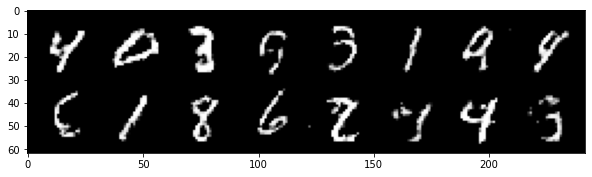

In [55]:
import matplotlib.pyplot as plt
grid_img = utils.make_grid(test_images)
plt.figure(figsize=(10,20))
plt.imshow(grid_img.permute(1,2,0))